In [14]:
import effector
import keras
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
bike_sharing = effector.datasets.BikeSharing(pcg_train=0.8)
X_train, Y_train = bike_sharing.x_train, bike_sharing.y_train
X_test, Y_test = bike_sharing.x_test, bike_sharing.y_test

In [15]:
# Define and train a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=1)
model.evaluate(X_test, Y_test, verbose=1)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6220 - mae: 0.5751 - root_mean_squared_error: 0.7851
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3867 - mae: 0.4507 - root_mean_squared_error: 0.6216
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2930 - mae: 0.3824 - root_mean_squared_error: 0.5411
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2149 - mae: 0.3252 - root_mean_squared_error: 0.4634
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1602 - mae: 0.2820 - root_mean_squared_error: 0.4000
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1148 - mae: 0.2334 - root_mean_squared_error: 0.3385
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0880 - mae: 0.2076 - root_mean_squared_error: 0.2966
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0734 - mae: 0.1887 - root_mean_squared_error: 0.2709
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0627 - mae: 0.1749 - root_mean_squar

[0.07368884235620499, 0.17802290618419647, 0.27145689725875854]

In [16]:
def predict(x):
    return model(x).numpy().squeeze()

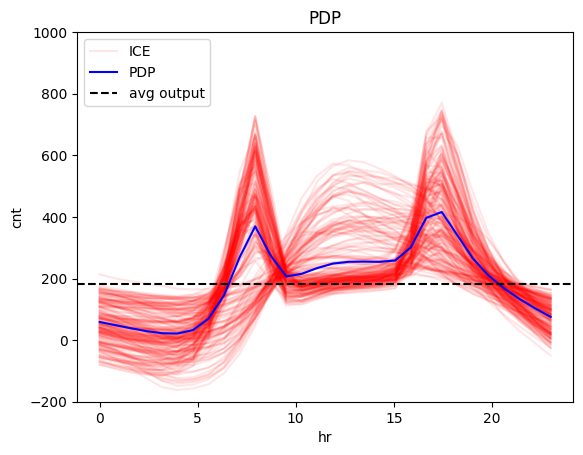

In [17]:
pdp = effector.PDP(
    X_test,
    predict,
    feature_names=bike_sharing.feature_names,
    target_name=bike_sharing.target_name
)

# plot the effect of the 3rd feature (feature: temperature)
pdp.plot(
    feature=3,
    nof_ice=200,
    scale_x={"mean": bike_sharing.x_test_mu[3], "std": bike_sharing.x_test_std[3]},
    scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},
    centering=True,
    show_avg_output=True,
    y_limits=[-200, 1000]
)


In [18]:
r_pdp = effector.RegionalPDP(
    X_test,
    predict,
    feature_names=bike_sharing.feature_names,
    target_name=bike_sharing.target_name
)

# summarize the subregions of feature 3
r_pdp.summary(
    features=3,
    scale_x_list=[{"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]} for i in range(X_test.shape[1])]
)


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.42 | inst: 3476 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.37 | inst: 1129 | w: 0.32]
        temp ≤ 6.50 🔹 [id: 3 | heter: 0.18 | inst: 568 | w: 0.16]
        temp > 6.50 🔹 [id: 4 | heter: 0.23 | inst: 561 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 2 | heter: 0.28 | inst: 2347 | w: 0.68]
        temp ≤ 6.50 🔹 [id: 5 | heter: 0.18 | inst: 953 | w: 0.27]
        temp > 6.50 🔹 [id: 6 | heter: 0.21 | inst: 1394 | w: 0.40]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.42
    Level 1🔹heter: 0.31 | 🔻0.11 (26.37%)
        Level 2🔹heter: 0.20 | 🔻0.11 (35.86%)




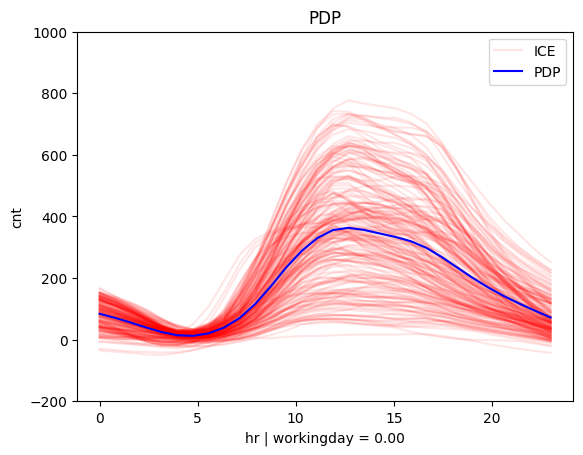

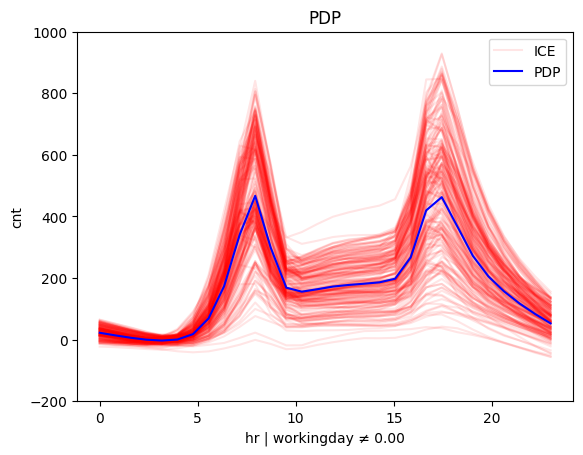

In [19]:
# plot the regional effects after the first-level split (workingday or non-workingday)
for node_idx in [1,2]:
    r_pdp.plot(
        feature=3,
        node_idx=node_idx,
        nof_ice=200,
        scale_x_list=[{"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]} for i in range(X_test.shape[1])],
        scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},
        y_limits=[-200, 1000]
    )


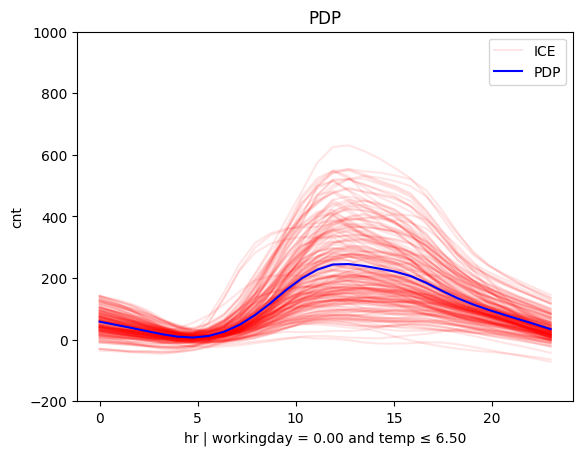

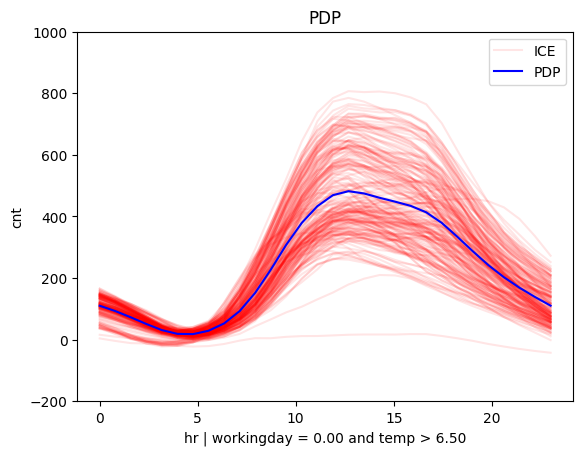

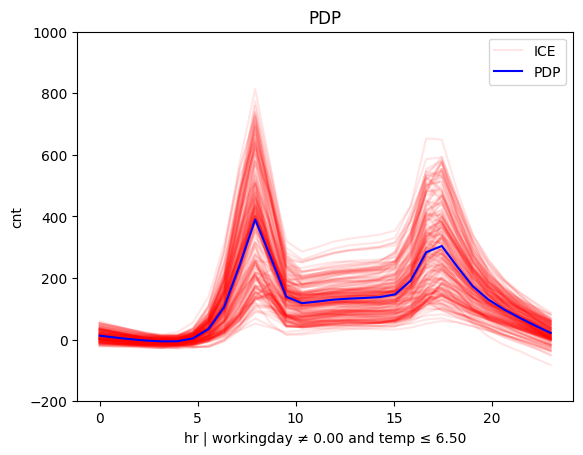

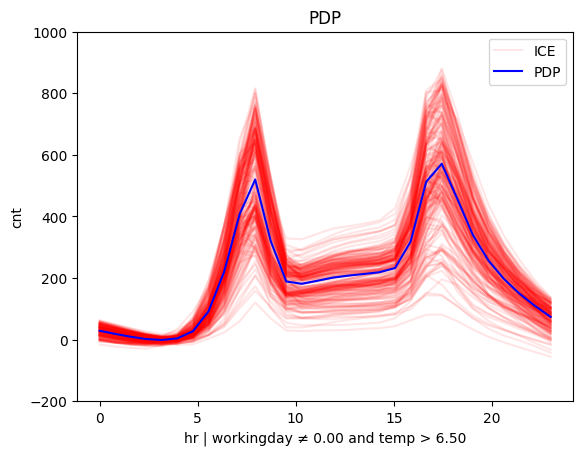

In [20]:
# plot the regional effects after the second-level splits (workingday or non-workingday and hot or cold temperature)
for node_idx in [3,4,5,6]:
    r_pdp.plot(
        feature=3,
        node_idx=node_idx,
        nof_ice=200,
        scale_x_list=[{"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]} for i in range(X_test.shape[1])],
        scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},
        y_limits=[-200, 1000]
    )
